# Modelo de Clasificación Local de Extremo a Extremo v2.1

Este notebook implementa un pipeline completo de Machine Learning de forma local con las siguientes características:

1.  **Carga de Datos**: Usa el dataset `hate_speech_twitter`.
2.  **Preprocesamiento de Texto**: Implementa una limpieza exhaustiva del texto, incluyendo tokenización, eliminación de stopwords y puntuación. Además, se realiza **stemming**.
3.  **Generación de Características Dual**: 
    - **Embeddings**: Convierte el texto limpio en vectores numéricos usando un modelo BERT pre-entrenado.
    - **TF-IDF**: Convierte el texto con stemming en una matriz dispersa usando TF-IDF.
4.  **Entrenamiento Multi-Modelo**: Entrena y optimiza cuatro modelos (XGBoost, MLP, Regresión Logística con Embeddings, y **Regresión Logística con TF-IDF**) usando **Optuna**.
5.  **Creación de Ensemble**: Combina los cuatro modelos en un **ensemble ponderado** para mejorar la precisión, con una lógica que maneja diferentes tipos de entrada.
6.  **Evaluación**: Evalúa el rendimiento del modelo ensemble final en un conjunto de prueba.

Todo el proceso se ejecuta localmente sin dependencias de la nube, aprovechando la GPU si está disponible.

## 1. Instalación y Configuración

In [1]:
#!pip install transformers torch datasets scikit-learn xgboost pandas seaborn matplotlib tqdm optuna nltk scipy

In [2]:
# --- CONFIGURACIÓN GENERAL ---
import pandas as pd
import numpy as np
import os
import pickle
import unicodedata
import seaborn as sns
import matplotlib.pyplot as plt
import time
import torch
import xgboost as xgb
from tqdm.auto import tqdm
import re

from datasets import load_dataset
from transformers import AutoTokenizer, AutoModel
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, log_loss, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer

# --- Configuración de NLTK para preprocesamiento de texto ---
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
try:
    stopwords.words('english')
except LookupError:
    print("Descargando recursos de NLTK (stopwords, punkt)...")
    nltk.download('stopwords')
    nltk.download('punkt')

# --- Parámetros de Configuración ---
BERT_MODEL_NAME = 'bert-base-uncased'
MAX_SAMPLES = 5000 # Limitar el número de muestras para que la ejecución sea más rápida. Poner a None para usar el dataset completo.
MAX_TOKEN_LENGTH = 128 # Max longitud para truncar/rellenar tokens.

# --- Configuración de Dispositivo (GPU o CPU) ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

# --- Definición de Rutas Locales ---
job_id = f"local-ensemble-job-{int(time.time())}"
BASE_DIR = "datos_locales"
PROCESSED_DIR = os.path.join(BASE_DIR, "processed", job_id)
MODEL_OUTPUT_DIR = os.path.join(BASE_DIR, "model_output", job_id)

os.makedirs(PROCESSED_DIR, exist_ok=True)
os.makedirs(MODEL_OUTPUT_DIR, exist_ok=True)

PROCESSED_DATA_PATH = os.path.join(PROCESSED_DIR, "processed_data_with_embeddings.csv")

print(f"\nID de trabajo para esta ejecución: {job_id}")
print(f"Ruta para datos procesados: {PROCESSED_DIR}")

c:\Users\emicr\anaconda3\envs\ml_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Usando dispositivo: cuda

ID de trabajo para esta ejecución: local-ensemble-job-1750829529
Ruta para datos procesados: datos_locales\processed\local-ensemble-job-1750829529


## 2. Carga, Limpieza y Tokenización de Datos

In [3]:
print("Cargando dataset 'thefrankhsu/hate_speech_twitter' desde Hugging Face...")
# NOTA: La primera vez que se ejecute, se descargarán y guardarán los datos en caché.
dataset = load_dataset("thefrankhsu/hate_speech_twitter")

# Combinamos los datos en un solo DataFrame de pandas
df = pd.DataFrame(dataset['train'])
print(f"Dataset cargado con {len(df)} filas.")
print("Columnas originales:", df.columns.tolist())

# Renombrar columnas para mayor claridad
df = df.rename(columns={'tweet': 'text_raw', 'label': 'target'})

# Tomar una muestra si se especificó para acelerar el proceso
if MAX_SAMPLES is not None:
    print(f"Tomando una muestra aleatoria de {MAX_SAMPLES} registros.")
    df = df.sample(n=MAX_SAMPLES, random_state=42).reset_index(drop=True)

print("\nDistribución de clases (en la muestra):")
print(df['target'].value_counts())

# Cargar tokenizador de BERT
print(f"\nCargando tokenizador de BERT: {BERT_MODEL_NAME}")
tokenizer_bert = AutoTokenizer.from_pretrained(BERT_MODEL_NAME)


Cargando dataset 'thefrankhsu/hate_speech_twitter' desde Hugging Face...
Dataset cargado con 5679 filas.
Columnas originales: ['tweet', 'label', 'categories']
Tomando una muestra aleatoria de 5000 registros.

Distribución de clases (en la muestra):
target
0    3657
1    1343
Name: count, dtype: int64

Cargando tokenizador de BERT: bert-base-uncased


### 2.1 Preprocesamiento Avanzado de Texto

Definimos una función para limpiar el texto. Esta función se aplicará de dos maneras:
1.  **Limpieza para Embeddings**: Tokenización, minúsculas, eliminación de puntuación y stopwords.
2.  **Limpieza para TF-IDF**: Ídem al anterior, más **stemming**.

Aplicando limpieza de texto para Embeddings (sin stemming)...


Limpiando Texto: 100%|██████████| 5000/5000 [00:00<00:00, 18092.31it/s]


Aplicando limpieza y stemming para TF-IDF...


Aplicando Stemming: 100%|██████████| 5000/5000 [00:00<00:00, 10969.80it/s]



Ejemplo de preprocesamiento:
Original: gambit ha he aint welcome in washington state or nashville serpas is straight trash
Limpio:   gambit ha aint welcome washington state nashville serpas straight trash
Stemmed:  gambit ha aint welcom washington state nashvil serpa straight trash

Analizando longitud de tokens (BERT) del texto limpio...


100%|██████████| 5000/5000 [00:00<00:00, 21841.33it/s]


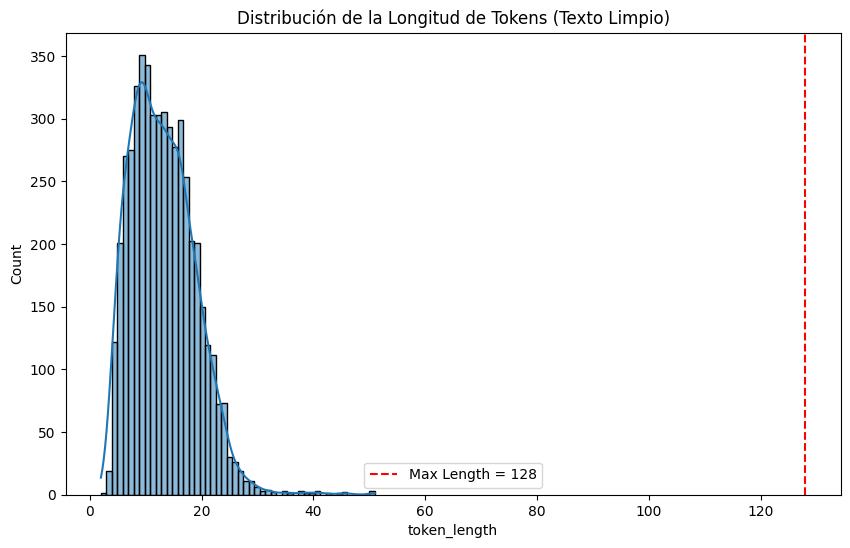

In [4]:
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

def clean_text(text, apply_stemming=False):
    """Limpia el texto: minúsculas, elimina URLs, puntuación y stopwords. Opcionalmente aplica stemming."""
    # CORRECCIÓN: Manejar valores nulos (None o NaN) que causan el TypeError
    if pd.isna(text):
        return ""
    
    # Eliminar URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Eliminar menciones de usuario y hashtags
    text = re.sub(r'\@\w+|#','', text)
    # Tokenizar
    tokens = word_tokenize(text)
    # Convertir a minúsculas y eliminar puntuación y stopwords
    words = [word.lower() for word in tokens if word.isalpha() and word.lower() not in stop_words]
    
    # Aplicar stemming si se solicita
    if apply_stemming:
        words = [stemmer.stem(word) for word in words]
        
    return " ".join(words)

print("Aplicando limpieza de texto para Embeddings (sin stemming)...")
tqdm.pandas(desc="Limpiando Texto")
df['text_cleaned'] = df['text_raw'].progress_apply(lambda x: clean_text(x, apply_stemming=False))

print("Aplicando limpieza y stemming para TF-IDF...")
tqdm.pandas(desc="Aplicando Stemming")
df['text_stemmed'] = df['text_cleaned'].progress_apply(lambda x: " ".join([stemmer.stem(word) for word in x.split()]))

print("\nEjemplo de preprocesamiento:")
print(f"Original: {df['text_raw'].iloc[0]}")
print(f"Limpio:   {df['text_cleaned'].iloc[0]}")
print(f"Stemmed:  {df['text_stemmed'].iloc[0]}")

# Analizar la longitud de los tokens del texto limpio que irá a BERT
print("\nAnalizando longitud de tokens (BERT) del texto limpio...")
df['token_length'] = [len(tokenizer_bert.encode(text, max_length=512, truncation=True)) for text in tqdm(df['text_cleaned'])]

plt.figure(figsize=(10, 6))
sns.histplot(df['token_length'], bins=50, kde=True)
plt.title('Distribución de la Longitud de Tokens (Texto Limpio)')
plt.axvline(x=MAX_TOKEN_LENGTH, color='r', linestyle='--', label=f'Max Length = {MAX_TOKEN_LENGTH}')
plt.legend()
plt.show()

## 3. Generación de Embeddings con BERT
Este es un paso computacionalmente intensivo. Usamos el `text_cleaned` como entrada.

In [5]:
print(f"Cargando modelo pre-entrenado: {BERT_MODEL_NAME}")
model = AutoModel.from_pretrained(BERT_MODEL_NAME).to(device)
model.eval() # Poner el modelo en modo de evaluación

def get_bert_embeddings(batch_text):
    """Tokeniza un lote de texto y obtiene el embedding [CLS] de BERT."""
    inputs = tokenizer_bert(batch_text, padding=True, truncation=True, 
                          max_length=MAX_TOKEN_LENGTH, return_tensors='pt')
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
    cls_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
    return cls_embeddings

print("\nGenerando embeddings... Esto puede tardar varios minutos.")
batch_size = 32
all_embeddings = []

for i in tqdm(range(0, len(df), batch_size)):
    batch_text = df.iloc[i:i+batch_size]['text_cleaned'].tolist()
    embeddings = get_bert_embeddings(batch_text)
    all_embeddings.append(embeddings)

final_embeddings = np.vstack(all_embeddings)

embedding_cols = [f'dim_{i}' for i in range(final_embeddings.shape[1])]
df_embeddings = pd.DataFrame(final_embeddings, columns=embedding_cols, index=df.index)

# Unir los embeddings con el dataframe original
df_processed = pd.concat([df, df_embeddings], axis=1)

# Guardar el resultado para los siguientes pasos
df_processed.to_csv(PROCESSED_DATA_PATH, index=False)

print(f"\n✓ Datos procesados (con embeddings) guardados en: {PROCESSED_DATA_PATH}")
print("Dimensiones del DataFrame final:", df_processed.shape)
print(df_processed.head())

Cargando modelo pre-entrenado: bert-base-uncased

Generando embeddings... Esto puede tardar varios minutos.


100%|██████████| 157/157 [00:04<00:00, 34.23it/s]



✓ Datos procesados (con embeddings) guardados en: datos_locales\processed\local-ensemble-job-1750829529\processed_data_with_embeddings.csv
Dimensiones del DataFrame final: (5000, 774)
                                            text_raw  target categories  \
0  gambit ha he aint welcome in washington state ...       0       None   
1    once it gets cold yall gonna be trash again lol       0       None   
2  np shy glizzy  awwsome remix feat  chainz amp ...       0       None   
3  just purchased my first trenta iced coffeethis...       0       None   
4  friday pm  vivek balk bengali harlem amp the l...       0       None   

                                        text_cleaned  \
0  gambit ha aint welcome washington state nashvi...   
1                    gets cold yall gon na trash lol   
2  np shy glizzy awwsome remix feat chainz amp aa...   
3  purchased first trenta iced coffeethis slipper...   
4  friday pm vivek balk bengali harlem amp lost h...   

                           

## 4. División y Codificación de Datos
Dividimos el dataset completo en entrenamiento, validación y prueba, asegurando que todas las características (embeddings, texto para TF-IDF) se dividan de forma consistente.

In [6]:
print("\n--- Ejecutando Lógica de División de Datos ---")

df = pd.read_csv(PROCESSED_DATA_PATH)
df['text_stemmed'] = df['text_stemmed'].fillna('') # Rellenar NaNs por si acaso
print(f"Datos cargados. {len(df)} filas.")

# Ya que es binario, no necesitamos filtrar clases
y = df['target'].values
num_classes = len(np.unique(y))
print(f"Se detectaron {num_classes} clases.")

# Dividir el DataFrame completo para mantener la alineación
print("Dividiendo los datos en conjuntos de entrenamiento, validación y prueba...")
df_trainval, df_test, y_trainval, y_test = train_test_split(
    df, y, test_size=0.2, random_state=42, stratify=y
)
df_train, df_val, y_train, y_val = train_test_split(
    df_trainval, y_trainval, test_size=0.25, random_state=42, stratify=y_trainval
)

print(f"Tamaño Train: {len(df_train)}, Val: {len(df_val)}, Test: {len(df_test)}")

# Extraer características para cada conjunto de datos
embedding_cols = [col for col in df.columns if col.startswith('dim_')]
X_train_emb = df_train[embedding_cols].values
X_val_emb = df_val[embedding_cols].values
X_test_emb = df_test[embedding_cols].values

X_train_text = df_train['text_stemmed'].values
X_val_text = df_val['text_stemmed'].values
X_test_text = df_test['text_stemmed'].values

# Guardar los datos de prueba para la evaluación final
with open(os.path.join(PROCESSED_DIR, 'test_embeddings.pkl'), 'wb') as f: pickle.dump(X_test_emb, f)
with open(os.path.join(PROCESSED_DIR, 'test_text_stemmed.pkl'), 'wb') as f: pickle.dump(X_test_text, f)
with open(os.path.join(PROCESSED_DIR, 'test_labels.pkl'), 'wb') as f: pickle.dump(y_test, f)

print(f"\n✓ División completada. Datos guardados en {PROCESSED_DIR}")


--- Ejecutando Lógica de División de Datos ---
Datos cargados. 5000 filas.
Se detectaron 2 clases.
Dividiendo los datos en conjuntos de entrenamiento, validación y prueba...
Tamaño Train: 3000, Val: 1000, Test: 1000

✓ División completada. Datos guardados en datos_locales\processed\local-ensemble-job-1750829529


## 5. Entrenamiento Multi-Modelo con Optuna

Optimizaremos cuatro modelos. Tres usarán los embeddings de BERT y uno nuevo usará características TF-IDF.

In [7]:
import optuna
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import warnings

warnings.filterwarnings('ignore', category=UserWarning)

print("--- Preparando datos para el entrenamiento ---")
# 1. Escalar características de embeddings
scaler = StandardScaler()
X_train_emb_scaled = scaler.fit_transform(X_train_emb)
X_val_emb_scaled = scaler.transform(X_val_emb)

# 2. Vectorizar características de texto con TF-IDF (usa Scipy internamente)
tfidf_vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_text)
X_val_tfidf = tfidf_vectorizer.transform(X_val_text)
print(f"TF-IDF: {X_train_tfidf.shape[1]} características generadas.")

# 3. Convertir datos de validación a tensores para PyTorch
X_val_torch = torch.tensor(X_val_emb_scaled, dtype=torch.float32).to(device)
y_val_torch = torch.tensor(y_val, dtype=torch.long).to(device)

print("\n✓ Datos escalados, vectorizados y tensores de PyTorch listos.")

--- Preparando datos para el entrenamiento ---
TF-IDF: 10000 características generadas.

✓ Datos escalados, vectorizados y tensores de PyTorch listos.


### 5.1 Definición de las Funciones Objetivo para Optuna

Cada función `objective` define cómo Optuna entrena y evalúa un modelo. El objetivo es minimizar `log_loss`.

In [8]:
# --- 1. Objetivo para MLP con PyTorch (Usa Embeddings) ---
class MLP(nn.Module):
    def __init__(self, input_size, hidden_layers, output_size, activation_fn, dropout_rate):
        super(MLP, self).__init__()
        layers = []
        current_size = input_size
        for hidden_size in hidden_layers:
            layers.append(nn.Linear(current_size, hidden_size))
            layers.append(activation_fn())
            layers.append(nn.Dropout(dropout_rate))
            current_size = hidden_size
        layers.append(nn.Linear(current_size, output_size))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

def objective_mlp(trial):
    n_layers = trial.suggest_int('n_layers', 1, 3)
    hidden_layers = [trial.suggest_int(f'n_units_l{i}', 32, 256) for i in range(n_layers)]
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'RMSprop'])
    lr = trial.suggest_float('lr', 1e-5, 1e-2, log=True)
    activation_fn = getattr(nn, trial.suggest_categorical('activation', ['ReLU', 'Tanh']))
    
    model = MLP(X_train_emb_scaled.shape[1], hidden_layers, num_classes, activation_fn, dropout_rate).to(device)
    optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    train_dataset = TensorDataset(torch.tensor(X_train_emb_scaled, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
    train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

    for epoch in range(25): # Menos epochs para HPO más rápido
        model.train()
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            loss = criterion(model(data), target)
            loss.backward()
            optimizer.step()
        
    model.eval()
    with torch.no_grad():
        val_loss = criterion(model(X_val_torch), y_val_torch).item()
    
    trial.report(val_loss, epoch)
    if trial.should_prune(): raise optuna.exceptions.TrialPruned()
    return val_loss

# --- 2. Objetivo para XGBoost (Usa Embeddings) ---
def objective_xgboost(trial):
    params = {
        'objective': 'binary:logistic' if num_classes == 2 else 'multi:softprob',
        'eval_metric': 'logloss' if num_classes == 2 else 'mlogloss',
        'device': 'cuda' if device.type == 'cuda' else 'cpu',
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 9),
    }
    model = xgb.XGBClassifier(**params, early_stopping_rounds=10, use_label_encoder=False)
    model.fit(X_train_emb, y_train, eval_set=[(X_val_emb, y_val)], verbose=False)
    return log_loss(y_val, model.predict_proba(X_val_emb))

# --- 3. Objetivo para Regresión Logística (Usa Embeddings) ---
def objective_logistic_embeddings(trial):
    params = {'C': trial.suggest_float('C', 1e-4, 1e2, log=True), 'solver': 'liblinear'}
    model = LogisticRegression(**params, random_state=42)
    model.fit(X_train_emb_scaled, y_train)
    return log_loss(y_val, model.predict_proba(X_val_emb_scaled))

# --- 4. NUEVO: Objetivo para Regresión Logística (Usa TF-IDF) ---
def objective_logistic_tfidf(trial):
    params = {'C': trial.suggest_float('C', 1e-2, 1e2, log=True), 'solver': 'liblinear'}
    model = LogisticRegression(**params, random_state=42)
    # Usa las características TF-IDF
    model.fit(X_train_tfidf, y_train)
    return log_loss(y_val, model.predict_proba(X_val_tfidf))

print(f"Funciones objetivo de Optuna definidas.")

Funciones objetivo de Optuna definidas.


### 5.2 Ejecución de la Búsqueda de Hiperparámetros
Lanzamos los estudios de Optuna para cada uno de los cuatro modelos.

In [9]:
models_config = {
    'XGBoost': {'objective_func': objective_xgboost, 'n_trials': 25},
    'MLP_PyTorch': {'objective_func': objective_mlp, 'n_trials': 30},
    'LogisticRegression_Embeddings': {'objective_func': objective_logistic_embeddings, 'n_trials': 20},
    'LogisticRegression_TFIDF': {'objective_func': objective_logistic_tfidf, 'n_trials': 20}
}

model_results = {}

for model_name, config in models_config.items():
    print(f"\n--- Optimizando {model_name} ---")
    study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=42))
    study.optimize(config['objective_func'], n_trials=config['n_trials'], show_progress_bar=True)
    
    model_results[model_name] = {
        'best_params': study.best_params,
        'best_score': study.best_value
    }
    print(f"✓ {model_name} completado. Mejor LogLoss: {study.best_value:.4f}")

[I 2025-06-24 23:32:28,052] A new study created in memory with name: no-name-1bfcf294-c7a0-4cb1-b836-aef8fbde07a0



--- Optimizando XGBoost ---


Best trial: 0. Best value: 0.441952:   4%|▍         | 1/25 [00:01<00:40,  1.69s/it]

[I 2025-06-24 23:32:29,732] Trial 0 finished with value: 0.4419518685769909 and parameters: {'n_estimators': 437, 'learning_rate': 0.2536999076681772, 'max_depth': 8}. Best is trial 0 with value: 0.4419518685769909.


Best trial: 1. Best value: 0.375628:   8%|▊         | 2/25 [00:05<01:06,  2.87s/it]

[I 2025-06-24 23:32:33,432] Trial 1 finished with value: 0.3756275011818982 and parameters: {'n_estimators': 639, 'learning_rate': 0.01700037298921102, 'max_depth': 4}. Best is trial 1 with value: 0.3756275011818982.


Best trial: 1. Best value: 0.375628:  12%|█▏        | 3/25 [00:06<00:46,  2.09s/it]

[I 2025-06-24 23:32:34,604] Trial 2 finished with value: 0.4176275118919651 and parameters: {'n_estimators': 152, 'learning_rate': 0.19030368381735815, 'max_depth': 7}. Best is trial 1 with value: 0.3756275011818982.


Best trial: 1. Best value: 0.375628:  16%|█▌        | 4/25 [00:25<03:05,  8.83s/it]

[I 2025-06-24 23:32:53,763] Trial 3 finished with value: 0.41761484367799917 and parameters: {'n_estimators': 737, 'learning_rate': 0.010725209743171996, 'max_depth': 9}. Best is trial 1 with value: 0.3756275011818982.


Best trial: 4. Best value: 0.369659:  20%|██        | 5/25 [00:29<02:19,  6.97s/it]

[I 2025-06-24 23:32:57,433] Trial 4 finished with value: 0.36965940257015417 and parameters: {'n_estimators': 850, 'learning_rate': 0.020589728197687916, 'max_depth': 4}. Best is trial 4 with value: 0.36965940257015417.


Best trial: 4. Best value: 0.369659:  24%|██▍       | 6/25 [00:33<01:56,  6.16s/it]

[I 2025-06-24 23:33:02,007] Trial 5 finished with value: 0.38523756121966973 and parameters: {'n_estimators': 265, 'learning_rate': 0.028145092716060652, 'max_depth': 6}. Best is trial 4 with value: 0.36965940257015417.


Best trial: 4. Best value: 0.369659:  28%|██▊       | 7/25 [00:38<01:43,  5.77s/it]

[I 2025-06-24 23:33:06,969] Trial 6 finished with value: 0.3995788677252723 and parameters: {'n_estimators': 489, 'learning_rate': 0.02692655251486473, 'max_depth': 7}. Best is trial 4 with value: 0.36965940257015417.


Best trial: 4. Best value: 0.369659:  32%|███▏      | 8/25 [00:41<01:21,  4.77s/it]

[I 2025-06-24 23:33:09,602] Trial 7 finished with value: 0.381394501171671 and parameters: {'n_estimators': 225, 'learning_rate': 0.027010527749605478, 'max_depth': 5}. Best is trial 4 with value: 0.36965940257015417.


Best trial: 4. Best value: 0.369659:  36%|███▌      | 9/25 [00:42<00:56,  3.51s/it]

[I 2025-06-24 23:33:10,356] Trial 8 finished with value: 0.3849677924737679 and parameters: {'n_estimators': 510, 'learning_rate': 0.14447746112718687, 'max_depth': 4}. Best is trial 4 with value: 0.36965940257015417.


Best trial: 9. Best value: 0.368914:  40%|████      | 10/25 [00:43<00:40,  2.68s/it]

[I 2025-06-24 23:33:11,176] Trial 9 finished with value: 0.3689144148185189 and parameters: {'n_estimators': 563, 'learning_rate': 0.07500118950416987, 'max_depth': 3}. Best is trial 9 with value: 0.3689144148185189.


Best trial: 9. Best value: 0.368914:  44%|████▍     | 11/25 [00:43<00:29,  2.10s/it]

[I 2025-06-24 23:33:11,950] Trial 10 finished with value: 0.37182897765272604 and parameters: {'n_estimators': 951, 'learning_rate': 0.09121222976475842, 'max_depth': 3}. Best is trial 9 with value: 0.3689144148185189.


Best trial: 9. Best value: 0.368914:  48%|████▊     | 12/25 [00:45<00:23,  1.83s/it]

[I 2025-06-24 23:33:13,165] Trial 11 finished with value: 0.37354473161121443 and parameters: {'n_estimators': 884, 'learning_rate': 0.05438690315385865, 'max_depth': 3}. Best is trial 9 with value: 0.3689144148185189.


Best trial: 9. Best value: 0.368914:  52%|█████▏    | 13/25 [00:46<00:20,  1.67s/it]

[I 2025-06-24 23:33:14,465] Trial 12 finished with value: 0.3800867933688345 and parameters: {'n_estimators': 717, 'learning_rate': 0.05789355613863403, 'max_depth': 4}. Best is trial 9 with value: 0.3689144148185189.


Best trial: 9. Best value: 0.368914:  56%|█████▌    | 14/25 [00:48<00:18,  1.65s/it]

[I 2025-06-24 23:33:16,063] Trial 13 finished with value: 0.38501740732968 and parameters: {'n_estimators': 826, 'learning_rate': 0.05715854510058415, 'max_depth': 5}. Best is trial 9 with value: 0.3689144148185189.


Best trial: 9. Best value: 0.368914:  60%|██████    | 15/25 [00:48<00:14,  1.44s/it]

[I 2025-06-24 23:33:17,037] Trial 14 finished with value: 0.37142257566328274 and parameters: {'n_estimators': 369, 'learning_rate': 0.08260257160095796, 'max_depth': 3}. Best is trial 9 with value: 0.3689144148185189.


Best trial: 9. Best value: 0.368914:  64%|██████▍   | 16/25 [00:56<00:28,  3.18s/it]

[I 2025-06-24 23:33:24,234] Trial 15 finished with value: 0.37678210847124083 and parameters: {'n_estimators': 636, 'learning_rate': 0.01044975763800043, 'max_depth': 5}. Best is trial 9 with value: 0.3689144148185189.


Best trial: 9. Best value: 0.368914:  68%|██████▊   | 17/25 [00:57<00:22,  2.77s/it]

[I 2025-06-24 23:33:26,045] Trial 16 finished with value: 0.3743826838785048 and parameters: {'n_estimators': 785, 'learning_rate': 0.037370046395123875, 'max_depth': 4}. Best is trial 9 with value: 0.3689144148185189.


Best trial: 9. Best value: 0.368914:  72%|███████▏  | 18/25 [01:01<00:20,  2.86s/it]

[I 2025-06-24 23:33:29,131] Trial 17 finished with value: 0.37312968637768607 and parameters: {'n_estimators': 999, 'learning_rate': 0.016358849852504267, 'max_depth': 3}. Best is trial 9 with value: 0.3689144148185189.


Best trial: 9. Best value: 0.368914:  76%|███████▌  | 19/25 [01:02<00:14,  2.47s/it]

[I 2025-06-24 23:33:30,690] Trial 18 finished with value: 0.39804032377136234 and parameters: {'n_estimators': 612, 'learning_rate': 0.09750750843844959, 'max_depth': 6}. Best is trial 9 with value: 0.3689144148185189.


Best trial: 9. Best value: 0.368914:  80%|████████  | 20/25 [01:04<00:11,  2.40s/it]

[I 2025-06-24 23:33:32,922] Trial 19 finished with value: 0.37914019330261517 and parameters: {'n_estimators': 374, 'learning_rate': 0.040250072422226335, 'max_depth': 5}. Best is trial 9 with value: 0.3689144148185189.


Best trial: 9. Best value: 0.368914:  84%|████████▍ | 21/25 [01:08<00:10,  2.71s/it]

[I 2025-06-24 23:33:36,357] Trial 20 finished with value: 0.3726786698075075 and parameters: {'n_estimators': 885, 'learning_rate': 0.018145792977098247, 'max_depth': 4}. Best is trial 9 with value: 0.3689144148185189.


Best trial: 9. Best value: 0.368914:  88%|████████▊ | 22/25 [01:09<00:06,  2.11s/it]

[I 2025-06-24 23:33:37,081] Trial 21 finished with value: 0.3703387166486488 and parameters: {'n_estimators': 363, 'learning_rate': 0.0881676847655526, 'max_depth': 3}. Best is trial 9 with value: 0.3689144148185189.


Best trial: 9. Best value: 0.368914:  92%|█████████▏| 23/25 [01:09<00:03,  1.63s/it]

[I 2025-06-24 23:33:37,576] Trial 22 finished with value: 0.38673767606247056 and parameters: {'n_estimators': 305, 'learning_rate': 0.13570390610987368, 'max_depth': 3}. Best is trial 9 with value: 0.3689144148185189.


Best trial: 9. Best value: 0.368914:  96%|█████████▌| 24/25 [01:10<00:01,  1.31s/it]

[I 2025-06-24 23:33:38,144] Trial 23 finished with value: 0.3781965145624714 and parameters: {'n_estimators': 105, 'learning_rate': 0.07506484887327174, 'max_depth': 3}. Best is trial 9 with value: 0.3689144148185189.


Best trial: 9. Best value: 0.368914: 100%|██████████| 25/25 [01:10<00:00,  2.83s/it]
[I 2025-06-24 23:33:38,894] A new study created in memory with name: no-name-49e33020-c811-43aa-8b91-c2f59c0e4c50


[I 2025-06-24 23:33:38,888] Trial 24 finished with value: 0.37926629207655344 and parameters: {'n_estimators': 587, 'learning_rate': 0.14397451657366406, 'max_depth': 4}. Best is trial 9 with value: 0.3689144148185189.
✓ XGBoost completado. Mejor LogLoss: 0.3689

--- Optimizando MLP_PyTorch ---


Best trial: 0. Best value: 0.415453:   3%|▎         | 1/30 [00:01<00:44,  1.53s/it]

[I 2025-06-24 23:33:40,421] Trial 0 finished with value: 0.41545286774635315 and parameters: {'n_layers': 2, 'n_units_l0': 245, 'n_units_l1': 196, 'dropout_rate': 0.3394633936788146, 'optimizer': 'Adam', 'lr': 1.493656855461762e-05, 'activation': 'ReLU'}. Best is trial 0 with value: 0.41545286774635315.


Best trial: 1. Best value: 0.398494:   7%|▋         | 2/30 [00:02<00:41,  1.48s/it]

[I 2025-06-24 23:33:41,868] Trial 1 finished with value: 0.39849424362182617 and parameters: {'n_layers': 3, 'n_units_l0': 36, 'n_units_l1': 250, 'n_units_l2': 219, 'dropout_rate': 0.18493564427131048, 'optimizer': 'RMSprop', 'lr': 8.17949947521167e-05, 'activation': 'ReLU'}. Best is trial 1 with value: 0.39849424362182617.


Best trial: 1. Best value: 0.398494:  10%|█         | 3/30 [00:04<00:36,  1.34s/it]

[I 2025-06-24 23:33:43,033] Trial 2 finished with value: 0.4593694508075714 and parameters: {'n_layers': 1, 'n_units_l0': 169, 'dropout_rate': 0.15579754426081674, 'optimizer': 'RMSprop', 'lr': 0.00023345864076016249, 'activation': 'ReLU'}. Best is trial 1 with value: 0.39849424362182617.


Best trial: 1. Best value: 0.398494:  13%|█▎        | 4/30 [00:05<00:35,  1.36s/it]

[I 2025-06-24 23:33:44,436] Trial 3 finished with value: 1.0824207067489624 and parameters: {'n_layers': 2, 'n_units_l0': 165, 'n_units_l1': 42, 'dropout_rate': 0.34301794076057535, 'optimizer': 'Adam', 'lr': 0.007025166339242158, 'activation': 'ReLU'}. Best is trial 1 with value: 0.39849424362182617.


Best trial: 4. Best value: 0.380902:  17%|█▋        | 5/30 [00:06<00:32,  1.30s/it]

[I 2025-06-24 23:33:45,632] Trial 4 finished with value: 0.3809016942977905 and parameters: {'n_layers': 1, 'n_units_l0': 53, 'dropout_rate': 0.3736932106048628, 'optimizer': 'Adam', 'lr': 0.0003058656666978527, 'activation': 'Tanh'}. Best is trial 4 with value: 0.3809016942977905.


Best trial: 5. Best value: 0.350412:  20%|██        | 6/30 [00:07<00:30,  1.26s/it]

[I 2025-06-24 23:33:46,812] Trial 5 finished with value: 0.3504122495651245 and parameters: {'n_layers': 1, 'n_units_l0': 181, 'dropout_rate': 0.2246844304357644, 'optimizer': 'RMSprop', 'lr': 3.585612610345396e-05, 'activation': 'ReLU'}. Best is trial 5 with value: 0.3504122495651245.


Best trial: 5. Best value: 0.350412:  23%|██▎       | 7/30 [00:09<00:31,  1.35s/it]

[I 2025-06-24 23:33:48,344] Trial 6 pruned. 


Best trial: 5. Best value: 0.350412:  27%|██▋       | 8/30 [00:10<00:30,  1.40s/it]

[I 2025-06-24 23:33:49,839] Trial 7 pruned. 


Best trial: 5. Best value: 0.350412:  30%|███       | 9/30 [00:12<00:28,  1.35s/it]

[I 2025-06-24 23:33:51,103] Trial 8 finished with value: 0.3840537667274475 and parameters: {'n_layers': 1, 'n_units_l0': 215, 'dropout_rate': 0.38274293753904687, 'optimizer': 'RMSprop', 'lr': 1.667761543019792e-05, 'activation': 'ReLU'}. Best is trial 5 with value: 0.3504122495651245.


Best trial: 5. Best value: 0.350412:  33%|███▎      | 10/30 [00:13<00:27,  1.38s/it]

[I 2025-06-24 23:33:52,528] Trial 9 pruned. 


Best trial: 5. Best value: 0.350412:  37%|███▋      | 11/30 [00:14<00:24,  1.31s/it]

[I 2025-06-24 23:33:53,693] Trial 10 pruned. 


Best trial: 5. Best value: 0.350412:  40%|████      | 12/30 [00:15<00:22,  1.27s/it]

[I 2025-06-24 23:33:54,879] Trial 11 pruned. 


Best trial: 5. Best value: 0.350412:  43%|████▎     | 13/30 [00:17<00:21,  1.29s/it]

[I 2025-06-24 23:33:56,194] Trial 12 pruned. 


Best trial: 5. Best value: 0.350412:  47%|████▋     | 14/30 [00:18<00:20,  1.26s/it]

[I 2025-06-24 23:33:57,395] Trial 13 pruned. 


Best trial: 5. Best value: 0.350412:  50%|█████     | 15/30 [00:19<00:18,  1.27s/it]

[I 2025-06-24 23:33:58,671] Trial 14 finished with value: 0.38950103521347046 and parameters: {'n_layers': 1, 'n_units_l0': 201, 'dropout_rate': 0.4505764863334542, 'optimizer': 'Adam', 'lr': 0.00023422328621630747, 'activation': 'Tanh'}. Best is trial 5 with value: 0.3504122495651245.


Best trial: 5. Best value: 0.350412:  53%|█████▎    | 16/30 [00:21<00:18,  1.29s/it]

[I 2025-06-24 23:34:00,024] Trial 15 pruned. 


Best trial: 5. Best value: 0.350412:  57%|█████▋    | 17/30 [00:22<00:16,  1.28s/it]

[I 2025-06-24 23:34:01,285] Trial 16 finished with value: 0.38353386521339417 and parameters: {'n_layers': 1, 'n_units_l0': 76, 'dropout_rate': 0.24695155488800646, 'optimizer': 'RMSprop', 'lr': 0.00016006854792293955, 'activation': 'Tanh'}. Best is trial 5 with value: 0.3504122495651245.


Best trial: 5. Best value: 0.350412:  60%|██████    | 18/30 [00:23<00:15,  1.32s/it]

[I 2025-06-24 23:34:02,692] Trial 17 finished with value: 0.37601155042648315 and parameters: {'n_layers': 2, 'n_units_l0': 141, 'n_units_l1': 208, 'dropout_rate': 0.10364018567409636, 'optimizer': 'Adam', 'lr': 3.5138524211670974e-05, 'activation': 'Tanh'}. Best is trial 5 with value: 0.3504122495651245.


Best trial: 5. Best value: 0.350412:  63%|██████▎   | 19/30 [00:25<00:14,  1.33s/it]

[I 2025-06-24 23:34:04,056] Trial 18 finished with value: 0.3543209135532379 and parameters: {'n_layers': 2, 'n_units_l0': 195, 'n_units_l1': 204, 'dropout_rate': 0.10189604786123588, 'optimizer': 'RMSprop', 'lr': 3.514784107276215e-05, 'activation': 'ReLU'}. Best is trial 5 with value: 0.3504122495651245.


Best trial: 5. Best value: 0.350412:  67%|██████▋   | 20/30 [00:26<00:13,  1.32s/it]

[I 2025-06-24 23:34:05,339] Trial 19 pruned. 


Best trial: 5. Best value: 0.350412:  70%|███████   | 21/30 [00:27<00:11,  1.31s/it]

[I 2025-06-24 23:34:06,623] Trial 20 finished with value: 0.353155255317688 and parameters: {'n_layers': 2, 'n_units_l0': 192, 'n_units_l1': 209, 'dropout_rate': 0.11042842300750604, 'optimizer': 'RMSprop', 'lr': 3.7901557047388606e-05, 'activation': 'ReLU'}. Best is trial 5 with value: 0.3504122495651245.


Best trial: 5. Best value: 0.350412:  73%|███████▎  | 22/30 [00:29<00:10,  1.30s/it]

[I 2025-06-24 23:34:07,910] Trial 21 finished with value: 0.35320329666137695 and parameters: {'n_layers': 2, 'n_units_l0': 185, 'n_units_l1': 211, 'dropout_rate': 0.10028961308750294, 'optimizer': 'RMSprop', 'lr': 3.246263999961898e-05, 'activation': 'ReLU'}. Best is trial 5 with value: 0.3504122495651245.


Best trial: 5. Best value: 0.350412:  77%|███████▋  | 23/30 [00:30<00:09,  1.31s/it]

[I 2025-06-24 23:34:09,230] Trial 22 finished with value: 0.35198625922203064 and parameters: {'n_layers': 2, 'n_units_l0': 217, 'n_units_l1': 166, 'dropout_rate': 0.18663197559690167, 'optimizer': 'RMSprop', 'lr': 2.443785516963524e-05, 'activation': 'ReLU'}. Best is trial 5 with value: 0.3504122495651245.


Best trial: 5. Best value: 0.350412:  80%|████████  | 24/30 [00:31<00:08,  1.35s/it]

[I 2025-06-24 23:34:10,686] Trial 23 pruned. 


Best trial: 5. Best value: 0.350412:  83%|████████▎ | 25/30 [00:33<00:06,  1.33s/it]

[I 2025-06-24 23:34:11,979] Trial 24 finished with value: 0.36066651344299316 and parameters: {'n_layers': 2, 'n_units_l0': 248, 'n_units_l1': 181, 'dropout_rate': 0.17364642819914874, 'optimizer': 'RMSprop', 'lr': 2.1850156068446692e-05, 'activation': 'ReLU'}. Best is trial 5 with value: 0.3504122495651245.


Best trial: 5. Best value: 0.350412:  87%|████████▋ | 26/30 [00:34<00:05,  1.33s/it]

[I 2025-06-24 23:34:13,291] Trial 25 pruned. 


Best trial: 5. Best value: 0.350412:  90%|█████████ | 27/30 [00:35<00:04,  1.36s/it]

[I 2025-06-24 23:34:14,730] Trial 26 pruned. 


Best trial: 5. Best value: 0.350412:  93%|█████████▎| 28/30 [00:37<00:02,  1.34s/it]

[I 2025-06-24 23:34:16,012] Trial 27 pruned. 


Best trial: 5. Best value: 0.350412:  97%|█████████▋| 29/30 [00:38<00:01,  1.30s/it]

[I 2025-06-24 23:34:17,235] Trial 28 finished with value: 0.3642427921295166 and parameters: {'n_layers': 1, 'n_units_l0': 213, 'dropout_rate': 0.13276108885909502, 'optimizer': 'RMSprop', 'lr': 2.2943976223859593e-05, 'activation': 'ReLU'}. Best is trial 5 with value: 0.3504122495651245.


Best trial: 5. Best value: 0.350412: 100%|██████████| 30/30 [00:39<00:00,  1.32s/it]
[I 2025-06-24 23:34:18,599] A new study created in memory with name: no-name-2c36cc08-480a-4629-a0f5-293ac75c3f15


[I 2025-06-24 23:34:18,599] Trial 29 pruned. 
✓ MLP_PyTorch completado. Mejor LogLoss: 0.3504

--- Optimizando LogisticRegression_Embeddings ---


Best trial: 0. Best value: 0.359715:   5%|▌         | 1/20 [00:00<00:08,  2.21it/s]

[I 2025-06-24 23:34:19,048] Trial 0 finished with value: 0.35971479754718827 and parameters: {'C': 0.017670169402947963}. Best is trial 0 with value: 0.35971479754718827.


Best trial: 0. Best value: 0.359715:  10%|█         | 2/20 [00:06<01:04,  3.57s/it]

[I 2025-06-24 23:34:24,798] Trial 1 finished with value: 4.127609283727132 and parameters: {'C': 50.61576888752309}. Best is trial 0 with value: 0.35971479754718827.


Best trial: 0. Best value: 0.359715:  15%|█▌        | 3/20 [00:08<00:47,  2.78s/it]

[I 2025-06-24 23:34:26,647] Trial 2 finished with value: 1.0656385822910042 and parameters: {'C': 2.465832945854912}. Best is trial 0 with value: 0.35971479754718827.


Best trial: 0. Best value: 0.359715:  20%|██        | 4/20 [00:09<00:33,  2.12s/it]

[I 2025-06-24 23:34:27,739] Trial 3 finished with value: 0.5654452378665452 and parameters: {'C': 0.39079671568228835}. Best is trial 0 with value: 0.35971479754718827.


Best trial: 0. Best value: 0.359715:  25%|██▌       | 5/20 [00:09<00:21,  1.42s/it]

[I 2025-06-24 23:34:27,937] Trial 4 finished with value: 0.4407593720311858 and parameters: {'C': 0.0008632008168602544}. Best is trial 0 with value: 0.35971479754718827.


Best trial: 0. Best value: 0.359715:  35%|███▌      | 7/20 [00:09<00:09,  1.36it/s]

[I 2025-06-24 23:34:28,175] Trial 5 finished with value: 0.4407778536203989 and parameters: {'C': 0.0008629132190071859}. Best is trial 0 with value: 0.35971479754718827.
[I 2025-06-24 23:34:28,318] Trial 6 finished with value: 0.5188135662548495 and parameters: {'C': 0.00022310108018679258}. Best is trial 0 with value: 0.35971479754718827.


Best trial: 0. Best value: 0.359715:  40%|████      | 8/20 [00:13<00:18,  1.58s/it]

[I 2025-06-24 23:34:31,698] Trial 7 finished with value: 2.589937650255491 and parameters: {'C': 15.741890047456648}. Best is trial 0 with value: 0.35971479754718827.


Best trial: 0. Best value: 0.359715:  45%|████▌     | 9/20 [00:14<00:15,  1.43s/it]

[I 2025-06-24 23:34:32,814] Trial 8 finished with value: 0.5707182580867118 and parameters: {'C': 0.4042872735027334}. Best is trial 0 with value: 0.35971479754718827.


Best trial: 0. Best value: 0.359715:  50%|█████     | 10/20 [00:15<00:14,  1.45s/it]

[I 2025-06-24 23:34:34,311] Trial 9 finished with value: 0.9326037516268549 and parameters: {'C': 1.7718847354806828}. Best is trial 0 with value: 0.35971479754718827.


Best trial: 10. Best value: 0.359707:  55%|█████▌    | 11/20 [00:16<00:10,  1.14s/it]

[I 2025-06-24 23:34:34,749] Trial 10 finished with value: 0.3597070463961975 and parameters: {'C': 0.017654677164766052}. Best is trial 10 with value: 0.3597070463961975.


Best trial: 10. Best value: 0.359707:  60%|██████    | 12/20 [00:16<00:07,  1.07it/s]

[I 2025-06-24 23:34:35,215] Trial 11 finished with value: 0.3600862259514163 and parameters: {'C': 0.018388382022356858}. Best is trial 10 with value: 0.3597070463961975.


Best trial: 12. Best value: 0.358178:  65%|██████▌   | 13/20 [00:17<00:05,  1.26it/s]

[I 2025-06-24 23:34:35,680] Trial 12 finished with value: 0.35817827557699683 and parameters: {'C': 0.012798666702408415}. Best is trial 12 with value: 0.35817827557699683.


Best trial: 12. Best value: 0.358178:  70%|███████   | 14/20 [00:17<00:04,  1.45it/s]

[I 2025-06-24 23:34:36,129] Trial 13 finished with value: 0.35817920243468415 and parameters: {'C': 0.012053282859112415}. Best is trial 12 with value: 0.35817827557699683.


Best trial: 12. Best value: 0.358178:  75%|███████▌  | 15/20 [00:17<00:02,  1.76it/s]

[I 2025-06-24 23:34:36,412] Trial 14 finished with value: 0.38439612324504935 and parameters: {'C': 0.0028718250465162133}. Best is trial 12 with value: 0.35817827557699683.


Best trial: 12. Best value: 0.358178:  80%|████████  | 16/20 [00:18<00:02,  1.61it/s]

[I 2025-06-24 23:34:37,154] Trial 15 finished with value: 0.39294993148444646 and parameters: {'C': 0.061296196372412286}. Best is trial 12 with value: 0.35817827557699683.


Best trial: 12. Best value: 0.358178:  85%|████████▌ | 17/20 [00:18<00:01,  1.92it/s]

[I 2025-06-24 23:34:37,445] Trial 16 finished with value: 0.37864778283731004 and parameters: {'C': 0.003409264942037956}. Best is trial 12 with value: 0.35817827557699683.


Best trial: 12. Best value: 0.358178:  90%|█████████ | 18/20 [00:19<00:01,  1.67it/s]

[I 2025-06-24 23:34:38,230] Trial 17 finished with value: 0.41332671501110074 and parameters: {'C': 0.08901581332229032}. Best is trial 12 with value: 0.35817827557699683.


Best trial: 12. Best value: 0.358178: 100%|██████████| 20/20 [00:20<00:00,  1.01s/it]
[I 2025-06-24 23:34:38,710] A new study created in memory with name: no-name-9b42fc0f-a0f2-4485-b1ad-12d01ce07ec7


[I 2025-06-24 23:34:38,561] Trial 18 finished with value: 0.372885969811759 and parameters: {'C': 0.00415403421342495}. Best is trial 12 with value: 0.35817827557699683.
[I 2025-06-24 23:34:38,705] Trial 19 finished with value: 0.5533478726005202 and parameters: {'C': 0.00011996661220636725}. Best is trial 12 with value: 0.35817827557699683.
✓ LogisticRegression_Embeddings completado. Mejor LogLoss: 0.3582

--- Optimizando LogisticRegression_TFIDF ---


Best trial: 0. Best value: 0.383562:   0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-06-24 23:34:38,732] Trial 0 finished with value: 0.3835621821785501 and parameters: {'C': 0.31489116479568624}. Best is trial 0 with value: 0.3835621821785501.


Best trial: 2. Best value: 0.228784:  40%|████      | 8/20 [00:00<00:00, 38.72it/s]

[I 2025-06-24 23:34:38,764] Trial 1 finished with value: 0.2438915994591586 and parameters: {'C': 63.512210106407046}. Best is trial 1 with value: 0.2438915994591586.
[I 2025-06-24 23:34:38,784] Trial 2 finished with value: 0.22878350451340182 and parameters: {'C': 8.471801418819979}. Best is trial 2 with value: 0.22878350451340182.
[I 2025-06-24 23:34:38,816] Trial 3 finished with value: 0.2543922106378524 and parameters: {'C': 2.481040974867813}. Best is trial 2 with value: 0.22878350451340182.
[I 2025-06-24 23:34:38,828] Trial 4 finished with value: 0.5266108481587011 and parameters: {'C': 0.04207988669606638}. Best is trial 2 with value: 0.22878350451340182.
[I 2025-06-24 23:34:38,833] Trial 5 finished with value: 0.5266210836329536 and parameters: {'C': 0.042070539502879395}. Best is trial 2 with value: 0.22878350451340182.
[I 2025-06-24 23:34:38,850] Trial 6 finished with value: 0.5575440516511149 and parameters: {'C': 0.017073967431528128}. Best is trial 2 with value: 0.22878350

Best trial: 2. Best value: 0.228784:  50%|█████     | 10/20 [00:00<00:00, 47.93it/s]

[I 2025-06-24 23:34:38,918] Trial 9 finished with value: 0.2309244491425294 and parameters: {'C': 6.79657809075816}. Best is trial 2 with value: 0.22878350451340182.
[I 2025-06-24 23:34:38,945] Trial 10 finished with value: 0.4248090148699596 and parameters: {'C': 0.19188765741731942}. Best is trial 2 with value: 0.22878350451340182.


Best trial: 11. Best value: 0.227363:  75%|███████▌  | 15/20 [00:00<00:00, 41.55it/s]

[I 2025-06-24 23:34:38,976] Trial 11 finished with value: 0.227362768728242 and parameters: {'C': 11.28150872288988}. Best is trial 11 with value: 0.227362768728242.
[I 2025-06-24 23:34:39,013] Trial 12 finished with value: 0.23179034178710975 and parameters: {'C': 28.77151152926683}. Best is trial 11 with value: 0.227362768728242.
[I 2025-06-24 23:34:39,033] Trial 13 finished with value: 0.2284611219654028 and parameters: {'C': 8.860401735171557}. Best is trial 11 with value: 0.227362768728242.
[I 2025-06-24 23:34:39,067] Trial 14 finished with value: 0.22779808236912713 and parameters: {'C': 9.955929698844178}. Best is trial 11 with value: 0.227362768728242.
[I 2025-06-24 23:34:39,088] Trial 15 finished with value: 0.35707882392118356 and parameters: {'C': 0.43622052582511206}. Best is trial 11 with value: 0.227362768728242.


Best trial: 11. Best value: 0.227363:  85%|████████▌ | 17/20 [00:00<00:00, 41.55it/s]

[I 2025-06-24 23:34:39,110] Trial 16 finished with value: 0.2734308521528483 and parameters: {'C': 1.5756479544296156}. Best is trial 11 with value: 0.227362768728242.
[I 2025-06-24 23:34:39,149] Trial 17 finished with value: 0.2474394048970068 and parameters: {'C': 75.96739093427765}. Best is trial 11 with value: 0.227362768728242.


Best trial: 18. Best value: 0.227299: 100%|██████████| 20/20 [00:00<00:00, 40.98it/s]

[I 2025-06-24 23:34:39,177] Trial 18 finished with value: 0.2272986844337548 and parameters: {'C': 14.646936393483898}. Best is trial 18 with value: 0.2272986844337548.
[I 2025-06-24 23:34:39,200] Trial 19 finished with value: 0.24179552741053625 and parameters: {'C': 3.757084358753148}. Best is trial 18 with value: 0.2272986844337548.
✓ LogisticRegression_TFIDF completado. Mejor LogLoss: 0.2273


### 5.3 Entrenamiento de los Modelos Finales
Ahora entrenamos cada modelo con los mejores hiperparámetros encontrados en el conjunto de entrenamiento completo.

In [10]:
trained_models = {}
print("--- Entrenando modelos finales con los mejores hiperparámetros ---")

# 1. XGBoost
params = model_results['XGBoost']['best_params']
final_xgb = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss',
                              device='cuda' if device.type == 'cuda' else 'cpu',
                              **params, use_label_encoder=False)
final_xgb.fit(X_train_emb, y_train)
trained_models['XGBoost'] = final_xgb
print("✓ Modelo XGBoost final entrenado.")

# 2. Regresión Logística (Embeddings)
params = model_results['LogisticRegression_Embeddings']['best_params']
final_log_emb = LogisticRegression(solver='liblinear', random_state=42, **params)
final_log_emb.fit(X_train_emb_scaled, y_train)
trained_models['LogisticRegression_Embeddings'] = final_log_emb
print("✓ Modelo Regresión Logística (Embeddings) final entrenado.")

# 3. Regresión Logística (TF-IDF)
params = model_results['LogisticRegression_TFIDF']['best_params']
final_log_tfidf = LogisticRegression(solver='liblinear', random_state=42, **params)
final_log_tfidf.fit(X_train_tfidf, y_train)
trained_models['LogisticRegression_TFIDF'] = final_log_tfidf
print("✓ Modelo Regresión Logística (TF-IDF) final entrenado.")

# 4. MLP (PyTorch)
params = model_results['MLP_PyTorch']['best_params']
hidden_layers = [params[f'n_units_l{i}'] for i in range(params['n_layers'])]
final_mlp = MLP(input_size=X_train_emb_scaled.shape[1], hidden_layers=hidden_layers, output_size=num_classes, 
                activation_fn=getattr(nn, params['activation']), dropout_rate=params['dropout_rate']).to(device)
optimizer = getattr(optim, params['optimizer'])(final_mlp.parameters(), lr=params['lr'])
criterion = nn.CrossEntropyLoss()
train_dataset = TensorDataset(torch.tensor(X_train_emb_scaled, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

for epoch in tqdm(range(30), desc="Epochs MLP final"):
    final_mlp.train()
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = final_mlp(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
trained_models['MLP_PyTorch'] = final_mlp.eval() # Poner en modo evaluación
print("✓ Modelo MLP (PyTorch) final entrenado.")

print("\n✓ Todos los modelos finales han sido entrenados.")

--- Entrenando modelos finales con los mejores hiperparámetros ---
✓ Modelo XGBoost final entrenado.
✓ Modelo Regresión Logística (Embeddings) final entrenado.
✓ Modelo Regresión Logística (TF-IDF) final entrenado.


Epochs MLP final: 100%|██████████| 30/30 [00:01<00:00, 20.34it/s]

✓ Modelo MLP (PyTorch) final entrenado.

✓ Todos los modelos finales han sido entrenados.


### 5.4 Creación y Evaluación del Ensemble Ponderado

Ahora, evaluamos cada modelo individualmente en el conjunto de validación para calcular sus pesos. Los modelos con menor `log_loss` (mejor rendimiento) recibirán más peso en el ensemble final. Finalmente, combinamos sus predicciones y evaluamos el rendimiento del ensemble.

In [11]:
print("--- Evaluando modelos individuales en el conjunto de validación ---")
individual_metrics = {}
val_probas = {}

# Obtener predicciones de cada modelo en el set de validación
val_probas['XGBoost'] = trained_models['XGBoost'].predict_proba(X_val_emb)
val_probas['LogisticRegression_Embeddings'] = trained_models['LogisticRegression_Embeddings'].predict_proba(X_val_emb_scaled)
val_probas['LogisticRegression_TFIDF'] = trained_models['LogisticRegression_TFIDF'].predict_proba(X_val_tfidf)
with torch.no_grad():
    mlp_outputs = trained_models['MLP_PyTorch'](X_val_torch)
    val_probas['MLP_PyTorch'] = torch.softmax(mlp_outputs, dim=1).cpu().numpy()

# Calcular métricas para cada modelo
for name, proba in val_probas.items():
    loss = log_loss(y_val, proba)
    pred = np.argmax(proba, axis=1)
    acc = accuracy_score(y_val, pred)
    f1 = f1_score(y_val, pred, average='weighted')
    individual_metrics[name] = {'log_loss': loss, 'accuracy': acc, 'f1_score': f1}

# Calcular pesos del ensemble (mayor peso a menor log_loss)
losses = {name: metrics['log_loss'] for name, metrics in individual_metrics.items()}
scores = {name: 1.0 / (loss + 1e-9) for name, loss in losses.items()}
total_score = sum(scores.values())
ensemble_weights = {name: score / total_score for name, score in scores.items()}

print("\n--- Pesos del Ensemble Calculados ---")
for name, w in ensemble_weights.items(): 
    print(f"{name:<30} | Peso: {w:.3f} | LogLoss (Val): {losses[name]:.4f}")

# Crear y evaluar el ensemble
ensemble_proba = np.zeros_like(val_probas['XGBoost'])
for name, proba in val_probas.items():
    ensemble_proba += proba * ensemble_weights[name]

ensemble_pred = np.argmax(ensemble_proba, axis=1)
ensemble_log_loss = log_loss(y_val, ensemble_proba)
ensemble_accuracy = accuracy_score(y_val, ensemble_pred)
ensemble_f1 = f1_score(y_val, ensemble_pred, average='weighted')

print("\n--- Comparación de Rendimiento (Validación) ---")
print(f"{'Modelo':<30} | {'Log Loss':<10} | {'Accuracy':<10} | {'F1-Score':<10}")
print("="*70)
for name, metrics in individual_metrics.items():
    print(f"{name:<30} | {metrics['log_loss']:<10.4f} | {metrics['accuracy']:<10.4f} | {metrics['f1_score']:<10.4f}")
print("—"*70)
print(f"{'🏆 ENSEMBLE PONDERADO':<30} | {ensemble_log_loss:<10.4f} | {ensemble_accuracy:<10.4f} | {ensemble_f1:<10.4f}")

--- Evaluando modelos individuales en el conjunto de validación ---

--- Pesos del Ensemble Calculados ---
XGBoost                        | Peso: 0.206 | LogLoss (Val): 0.3834
LogisticRegression_Embeddings  | Peso: 0.220 | LogLoss (Val): 0.3582
LogisticRegression_TFIDF       | Peso: 0.347 | LogLoss (Val): 0.2273
MLP_PyTorch                    | Peso: 0.226 | LogLoss (Val): 0.3490

--- Comparación de Rendimiento (Validación) ---
Modelo                         | Log Loss   | Accuracy   | F1-Score  
XGBoost                        | 0.3834     | 0.8530     | 0.8441    
LogisticRegression_Embeddings  | 0.3582     | 0.8540     | 0.8518    
LogisticRegression_TFIDF       | 0.2273     | 0.9120     | 0.9098    
MLP_PyTorch                    | 0.3490     | 0.8640     | 0.8592    
——————————————————————————————————————————————————————————————————————
🏆 ENSEMBLE PONDERADO           | 0.2624     | 0.9010     | 0.8971    


## 6. Evaluación Final del Modelo Ensemble (en Conjunto de Prueba)
Aplicamos la lógica del ensemble al conjunto de prueba, que los modelos no han visto nunca.


--- Ejecutando Evaluación Final del Ensemble en el Conjunto de Prueba ---
Datos de prueba cargados: 1000 muestras.

--- Resultados de la Evaluación Final ---
Accuracy en el conjunto de prueba: 0.9110

Reporte de Clasificación:
              precision    recall  f1-score   support

    not-hate       0.91      0.98      0.94       731
        hate       0.92      0.74      0.82       269

    accuracy                           0.91      1000
   macro avg       0.91      0.86      0.88      1000
weighted avg       0.91      0.91      0.91      1000


Matriz de Confusión:


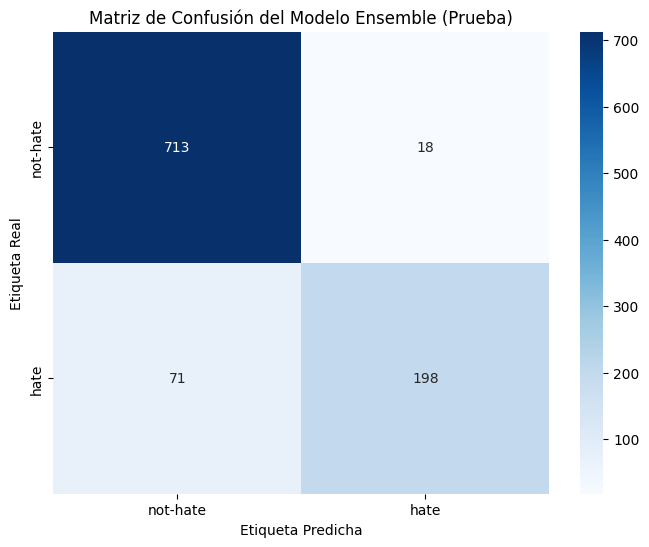


--- Evaluación Completada ---


In [12]:
print("\n--- Ejecutando Evaluación Final del Ensemble en el Conjunto de Prueba ---")

# 1. Cargar los datos de prueba
with open(os.path.join(PROCESSED_DIR, 'test_embeddings.pkl'), 'rb') as f: X_test_emb_eval = pickle.load(f)
with open(os.path.join(PROCESSED_DIR, 'test_text_stemmed.pkl'), 'rb') as f: X_test_text_eval = pickle.load(f)
with open(os.path.join(PROCESSED_DIR, 'test_labels.pkl'), 'rb') as f: y_test_eval = pickle.load(f)
print(f"Datos de prueba cargados: {len(y_test_eval)} muestras.")

# 2. Preparar características de prueba
X_test_emb_scaled_eval = scaler.transform(X_test_emb_eval)
X_test_tfidf_eval = tfidf_vectorizer.transform(X_test_text_eval)
X_test_torch_eval = torch.tensor(X_test_emb_scaled_eval, dtype=torch.float32).to(device)

# 3. Obtener predicciones de cada modelo en el conjunto de prueba
test_probas = {}
test_probas['XGBoost'] = trained_models['XGBoost'].predict_proba(X_test_emb_eval)
test_probas['LogisticRegression_Embeddings'] = trained_models['LogisticRegression_Embeddings'].predict_proba(X_test_emb_scaled_eval)
test_probas['LogisticRegression_TFIDF'] = trained_models['LogisticRegression_TFIDF'].predict_proba(X_test_tfidf_eval)
with torch.no_grad():
    mlp_outputs = trained_models['MLP_PyTorch'](X_test_torch_eval)
    test_probas['MLP_PyTorch'] = torch.softmax(mlp_outputs, dim=1).cpu().numpy()

# 4. Combinar predicciones usando los pesos del ensemble
final_ensemble_proba = np.zeros_like(test_probas['XGBoost'])
for name, proba in test_probas.items():
    final_ensemble_proba += proba * ensemble_weights[name]

y_pred_eval = np.argmax(final_ensemble_proba, axis=1)

# 5. Calcular y mostrar métricas finales
print("\n--- Resultados de la Evaluación Final ---")
acc = accuracy_score(y_test_eval, y_pred_eval)
report = classification_report(y_test_eval, y_pred_eval, target_names=['not-hate', 'hate'])
cm = confusion_matrix(y_test_eval, y_pred_eval)

print(f"Accuracy en el conjunto de prueba: {acc:.4f}\n")
print("Reporte de Clasificación:")
print(report)

print("\nMatriz de Confusión:")
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['not-hate', 'hate'], yticklabels=['not-hate', 'hate'])
plt.ylabel('Etiqueta Real')
plt.xlabel('Etiqueta Predicha')
plt.title('Matriz de Confusión del Modelo Ensemble (Prueba)')
plt.show()

print("\n--- Evaluación Completada ---")

## 7. Guardado de Artefactos del Modelo

Guardamos los modelos individuales, los transformadores de características (scaler y TF-IDF), los pesos del ensemble y los resultados de Optuna.

In [13]:
print(f"--- Guardando artefactos en {MODEL_OUTPUT_DIR} ---")

# 1. Guardar los pesos del ensemble
weights_path = os.path.join(MODEL_OUTPUT_DIR, "ensemble_weights.pkl")
with open(weights_path, 'wb') as f: pickle.dump(ensemble_weights, f)
print(f"✓ Pesos del ensemble guardados en: {weights_path}")

# 2. Guardar los modelos individuales
for name, model in trained_models.items():
    if name == 'MLP_PyTorch':
        model_path = os.path.join(MODEL_OUTPUT_DIR, "mlp_pytorch.pth")
        torch.save(model.state_dict(), model_path)
    else:
        model_path = os.path.join(MODEL_OUTPUT_DIR, f"{name.lower()}_model.pkl")
        with open(model_path, 'wb') as f: pickle.dump(model, f)
    print(f"✓ Modelo {name} guardado en: {model_path}")

# 3. Guardar los transformadores de características
scaler_path = os.path.join(MODEL_OUTPUT_DIR, "scaler.pkl")
with open(scaler_path, 'wb') as f: pickle.dump(scaler, f)
print(f"✓ Scaler guardado en: {scaler_path}")

tfidf_path = os.path.join(MODEL_OUTPUT_DIR, "tfidf_vectorizer.pkl")
with open(tfidf_path, 'wb') as f: pickle.dump(tfidf_vectorizer, f)
print(f"✓ Vectorizador TF-IDF guardado en: {tfidf_path}")

# 4. Guardar los resultados de Optuna
results_path = os.path.join(MODEL_OUTPUT_DIR, "optuna_results.pkl")
with open(results_path, 'wb') as f: pickle.dump(model_results, f)
print(f"✓ Resultados de Optuna guardados en: {results_path}")

print("\n🎉 Pipeline completado y todos los artefactos han sido guardados.")

--- Guardando artefactos en datos_locales\model_output\local-ensemble-job-1750829529 ---
✓ Pesos del ensemble guardados en: datos_locales\model_output\local-ensemble-job-1750829529\ensemble_weights.pkl
✓ Modelo XGBoost guardado en: datos_locales\model_output\local-ensemble-job-1750829529\xgboost_model.pkl
✓ Modelo LogisticRegression_Embeddings guardado en: datos_locales\model_output\local-ensemble-job-1750829529\logisticregression_embeddings_model.pkl
✓ Modelo LogisticRegression_TFIDF guardado en: datos_locales\model_output\local-ensemble-job-1750829529\logisticregression_tfidf_model.pkl
✓ Modelo MLP_PyTorch guardado en: datos_locales\model_output\local-ensemble-job-1750829529\mlp_pytorch.pth
✓ Scaler guardado en: datos_locales\model_output\local-ensemble-job-1750829529\scaler.pkl
✓ Vectorizador TF-IDF guardado en: datos_locales\model_output\local-ensemble-job-1750829529\tfidf_vectorizer.pkl
✓ Resultados de Optuna guardados en: datos_locales\model_output\local-ensemble-job-1750829529\o